# Convolutional Neural Networks (CNNs)

The purpose of this notebook is to practice implementing and training CNNs. We start with a 1-dimensional convolutional layer in [NumPy](https://numpy.org/doc/).

We will then use [PyTorch](https://pytorch.org/), an optimised machine learning framework for Python based on the `torch` library to implement machine learning architectures.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Importing losses, activation functions and layers from PyTorch 
from torch.nn import Sequential, CrossEntropyLoss, Conv1d, MaxPool1d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

# Changing default font sizes
plt.rc('xtick', labelsize=8) # Tick labels
plt.rc('ytick', labelsize=8) # Tick labels
plt.rc('legend', fontsize=10) # Legend
plt.rc('axes', titlesize=15, labelsize=10) # Title and 'x' and 'y' labels

You will be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. This consists of the readings from an accelerometer carried by a human doing different activities. The six activities are: walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and it takes six readings every 0.02 seconds: linear and gyroscopic acceleration in the x, y and z directions.

The goal is to use the accelerometer data to **predict the type of activity** (a multi-class classification task).

## 1. Loading and plotting the data

In [8]:
x_train = np.load('./data/HAR/x_train.npy')
y_train = np.load('./data/HAR/y_train.npy')

x_val = np.load('./data/HAR/x_val.npy')
y_val = np.load('./data/HAR/y_val.npy')

x_test = np.load('./data/HAR/x_test.npy')
y_test = np.load('./data/HAR/y_test.npy')

The input data consists of 6 features over 128 time steps, and the output is a single integer from 0 to 5, which denotes the class.

There are 7352 examples in the training set, 2447 examples in the validation set and 500 in the test set. We can check the shapes ourselves.

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(7352, 6, 128)
(7352, 1)
(2447, 6, 128)
(2447, 1)
(500, 6, 128)
(500, 1)


In [10]:
print(x_train)

[[[ 1.808515e-04  1.013856e-02  9.275574e-03 ... -1.147484e-03
   -2.222655e-04  1.575500e-03]
  [ 1.076681e-02  6.579480e-03  8.928878e-03 ...  1.714439e-04
    1.574181e-03  3.070189e-03]
  [ 5.556068e-02  5.512483e-02  4.840473e-02 ...  2.647864e-03
    2.381057e-03 -2.269757e-03]
  [ 3.019122e-02  4.371071e-02  3.568780e-02 ...  3.985177e-02
    3.744932e-02  2.881781e-02]
  [ 6.601362e-02  4.269897e-02  7.485018e-02 ...  1.909445e-03
   -7.982483e-05 -3.771800e-05]
  [ 2.285864e-02  1.031572e-02  1.324969e-02 ... -2.170124e-03
   -5.642633e-03 -1.446006e-03]]

 [[ 1.093752e-03  4.550077e-03  2.879173e-03 ... -4.646144e-03
   -2.941333e-03 -1.598751e-03]
  [-4.687588e-03 -7.487894e-03 -8.429991e-03 ... -5.479850e-03
   -2.987481e-03 -7.192009e-03]
  [-2.685954e-02 -2.509841e-02 -2.597534e-02 ... -2.996671e-04
   -4.886324e-03 -3.397195e-03]
  [ 1.711106e-02  2.417851e-02  3.022889e-02 ... -3.474078e-02
   -3.797305e-02 -3.864973e-02]
  [ 6.122797e-03  9.710357e-03  1.032192e-02 ...

In [11]:
classes = [
    'Walking',
    'Walking upstairs',
    'Walking downstairs',
    'Sitting',
    'Standing',
    'Laying'
]

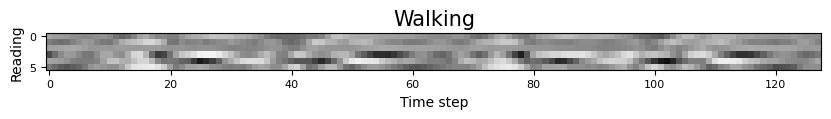

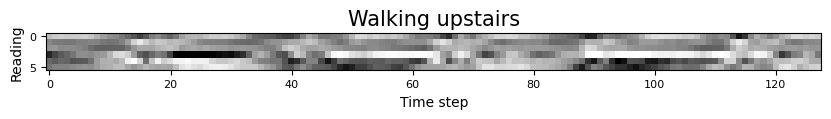

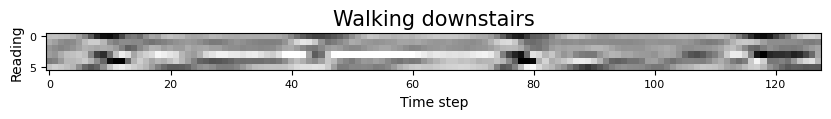

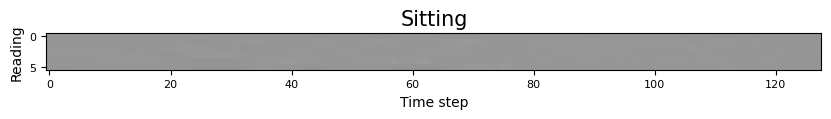

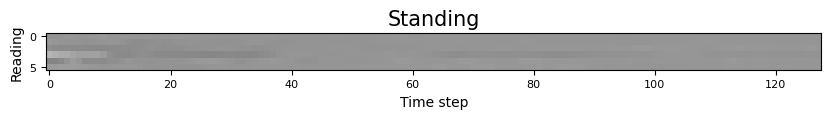

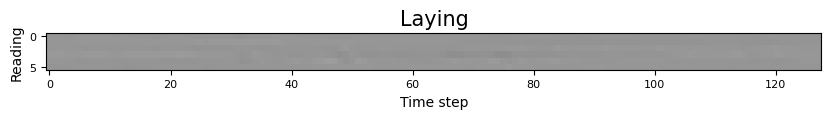

In [12]:
# Plot a randomly selected example from each class

for l, label in enumerate(range(len(classes))):
    inx = np.where(y_train[:, 0] == label)[0]
    i = np.random.choice(inx)
    x_example = x_train[i].T
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_example.T, cmap='Greys', vmin=-1, vmax=1)
    ax.set_ylabel('Reading')
    ax.set_xlabel('Time step')
    ax.set_title(classes[l])

## 2. 1D convolutional layer in NumPy

Now we will implement a 1D convolutional layer in `numpy`. The following function is designed to perform a 1D convolution on an input signal, given `weight` and `bias` parameters. The layer should have no `padding` and a `stride` of 1. The output should consist of the pre-activations of the layer, meaning that no activation function is then applied.

### Notation

* `c_in` and `c_out` (equal to `n_filters`) represent the number of input and output channels (respectively).
* `l_in` and `l_out` denote the length of the input and output signals (respectively).
* `k` is the length of the convolving kernel/filter.

For a convolutional (or max pool) layer, the input and output lengths are related as follows:

$$l_{out}=\left\lfloor\frac{l_{in}+2×\text{padding}-\text{kernel\_size}}{\text{stride}}+1\right\rfloor$$

In [13]:
def conv1d(x, weight, bias):
    """
    Performs a 1D convolution over an input signal.

    Parameters:
    x: Input signal of shape (batch_size, c_in, l_in)
    weight: Learnable weights, shape (c_in, c_out, k)
    bias: Bias parameters of size c_out

    Returns:
    An array of shape (batch_size, c_out, l_out)

    """
    batch_size = x.shape[0] 
    l_in = x.shape[2]
    c_out = weight.shape[0]
    k = weight.shape[2] 

    l_out = l_in - k + 1 
    outputs = np.zeros((batch_size, c_out, l_out))
    np.testing.assert_allclose(l_out, 113)

    for i in range(l_out):
        outputs[:, :, i] = (x[:, np.newaxis, :, i:i+k] * weight).sum(axis=(2, 3)) + bias 
    return outputs

Now we can compare our layer with the PyTorch implementation.

In [14]:
# Test your layer
n_filters = 8
batch_size = 16
k = 16
l_in = 128

# PyTorch
conv_layer = Conv1d(x_train.shape[1], n_filters, k)
inputs = torch.randn((batch_size, x_train.shape[1], l_in))
y_torch = conv_layer(inputs)

# Our layer
y = conv1d(inputs.numpy(), conv_layer.weight.detach().numpy(), conv_layer.bias.detach().numpy())
np.allclose(y, y_torch.detach().numpy(), atol=1e-4)  ## <-- should be 'True'


True

### 3. Building a CNN in PyTorch

You should now build the CNN model in PyTorch to train on the HAR dataset. This model should consist of:

* A `Conv1d` layer with 8 filters, kernel size of 16 and a `ReLU` activation function
  * The input shape should be `(6, 128)`
  * This layer should use l2 weight regularisation with a coefficient of 1e-3
* A `MaxPoo1d` layer with a pooling window size of 16 and a stride of 2
* A `Flatten` layer
* A `Linear` layer with 6 neurons and a `Softmax` activation
  * This layer should use l2 weight regularisation with a coefficient of 1e-3

The function below should build and compile this model, using an `Adam` optimiser and a `CrossEntropyLoss` criterion.

In [15]:
def get_model(x_train, n_filters, k, pool_size, stride_pool, classes, l2_reg=1e-3):
    """
    CNN model in PyTorch:
    - Layers are Conv1d(+ReLU), MaxPool1d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.
    - Conv1d and Linear layers have regularised weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters: Number of filters to be used in the convolutional layer
    k: Kernel size in the convolutional layer
    pool_size: MaxPool1d window size
    stride_pool: Stride of the MaxPool1d sliding window
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularisation coefficient of Conv1d and Linear

    Returns:
    Model, criterion and optimiser.

    """

    l_out_conv = x_train.shape[2] - k + 1 # Length after Conv1d (note that the stride is 1)
    l_out_pool = (l_out_conv - pool_size) // stride_pool + 1 # Length after MaxPool1d 
    l_in_linear = n_filters * l_out_pool # Size before Linear layer
    np.testing.assert_allclose(l_in_linear, 392)

    model = Sequential(
        Conv1d(x_train.shape[1], n_filters, kernel_size=k),
        ReLU(),
        MaxPool1d(kernel_size=pool_size, stride=stride_pool), 
        Flatten(), 
        Linear(l_in_linear, len(classes)), 
        Softmax(dim=1),
    )

    # L2 regularisation
    for layer in model.children():
        if isinstance(layer, Conv1d) or isinstance(layer, Linear):
            layer.weight_regularizer = Parameter(l2_reg * torch.ones_like(layer.weight))

    criterion = CrossEntropyLoss() 
    optimiser = torch.optim.Adam(model.parameters())
    
    return model, criterion, optimiser

In [16]:
# Run your function to get the model and print it

n_filters = 8
k = 16
pool_size = 16
stride_pool = 2
l2_reg = 1e-3

model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes, l2_reg) 
print(model)

Sequential(
  (0): Conv1d(6, 8, kernel_size=(16,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=16, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=392, out_features=6, bias=True)
  (5): Softmax(dim=1)
)


## 4. Training a CNN

Now we are ready to train the model. The `training_loop` function should run the training for `max_num_epochs` of 200 and `batch_size` of 128, featuring early stopping to monitor the validation accuracy. Set the `max_patience` parameter to 5 epochs. The function should return the training and validation history, which includes the loss and accuracy.

In [17]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [18]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') 
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:  
            self.best_valid_loss = val_loss  
            self.patience = 0  
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [19]:
def training_loop(train_loader, val_loader, max_num_epochs=200, max_patience=5):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class

    Returns:
    Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))  
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0)) 

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
        print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping acting.")  
            break 

    return history


In [20]:
# Calling the training loop
max_num_epochs = 200
max_patience = 5

history = training_loop(train_loader, val_loader, max_num_epochs, max_patience)

Epoch 1/200, Training loss: 1.7159617276027286, Training accuracy: 24.836437807881776%, Validation loss: 1.6682752966880798, Validation accuracy: 44.195312499999986%
Epoch 2/200, Training loss: 1.540783810204473, Training accuracy: 56.62523091133003%, Validation loss: 1.495812439918518, Validation accuracy: 61.89322916666665%
Epoch 3/200, Training loss: 1.4302882490486934, Training accuracy: 62.96374692118225%, Validation loss: 1.438865500688553, Validation accuracy: 60.08072916666667%
Epoch 4/200, Training loss: 1.3932829026518196, Training accuracy: 64.3607604679803%, Validation loss: 1.4169990301132203, Validation accuracy: 61.29166666666666%
Epoch 5/200, Training loss: 1.3759199483641262, Training accuracy: 65.04387315270938%, Validation loss: 1.4077630400657655, Validation accuracy: 61.36979166666667%
Epoch 6/200, Training loss: 1.3669536504252204, Training accuracy: 66.721828817734%, Validation loss: 1.4032866537570954, Validation accuracy: 61.83854166666668%


KeyboardInterrupt: 

In [ ]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

## 5. Evaluating the test performance of a CNN

Now let's take a look at some model predictions!

In [21]:
# Get the model predictions
preds = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

In [24]:
#print(preds)

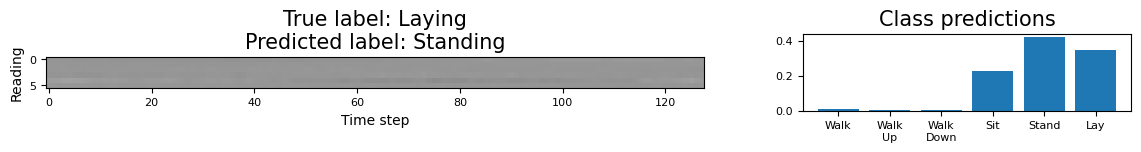

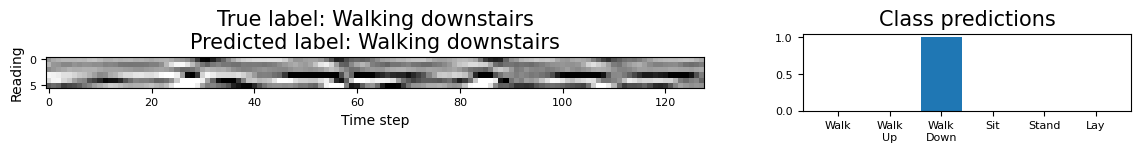

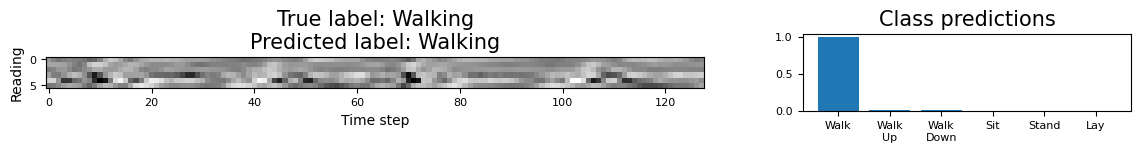

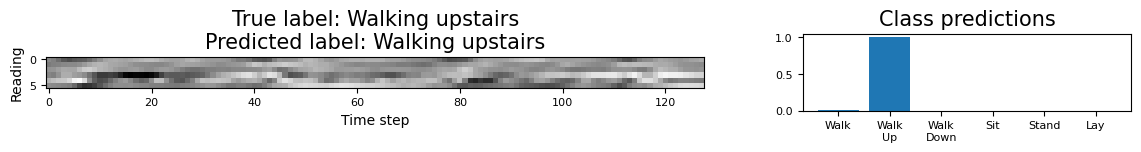

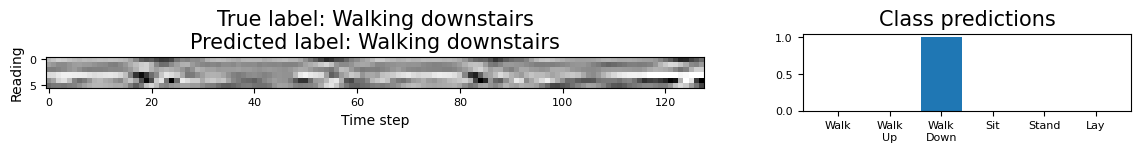

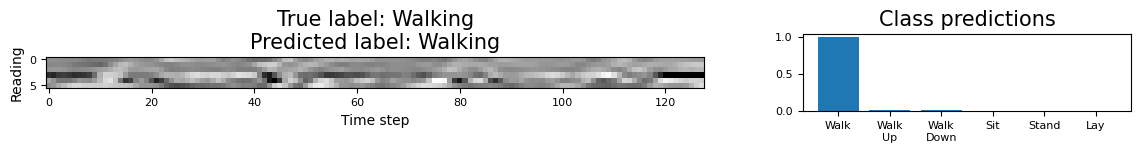

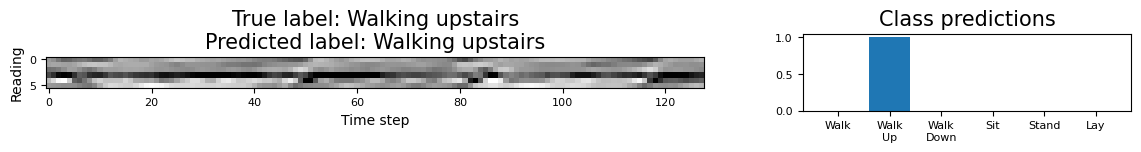

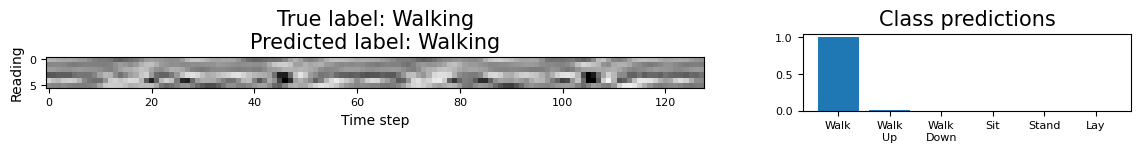

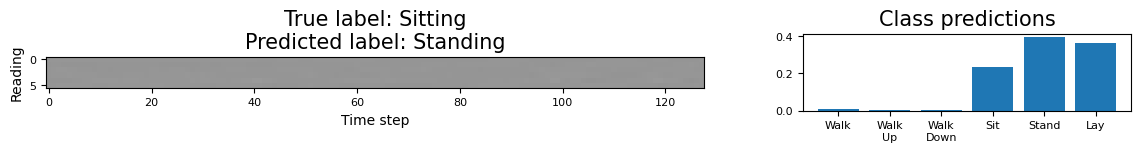

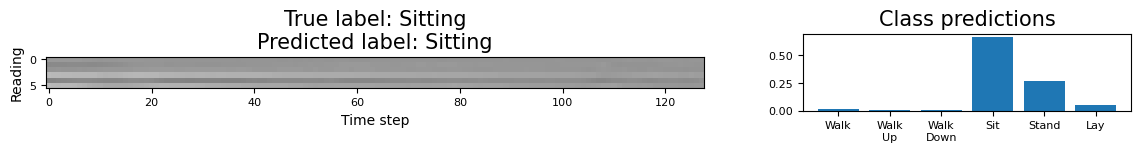

In [22]:
# Plot some example predictions

num_preds = preds.shape[0]
num_examples = 10
inx = np.random.choice(num_preds, num_examples, replace=False)
gs = {"width_ratios": [2, 1]}

for i in inx:
    x_example = x_test[i]
    true_label = y_test[i][0]
    prediction = preds[i]
    pred_class = np.argmax(prediction)
    fig, ax = plt.subplots(figsize=(14, 1), ncols=2, gridspec_kw=gs)
    ax[0].imshow(x_example, cmap='Greys', vmin=-1, vmax=1)
    ax[0].set_ylabel('Reading')
    ax[0].set_xlabel('Time step')
    ax[0].set_title("True label: {}\nPredicted label: {}".format(classes[true_label], classes[pred_class]))
    ax[1].bar(['Walk', 'Walk\nUp', 'Walk\nDown', 'Sit', 'Stand', 'Lay'], prediction)
    ax[1].set_title("Class predictions")

### Questions
1. Are there particular classes where the model tends to be more uncertain in its predictions?
2. What effect does the weight regularisation have on the training and the final model? Try experimenting with no weight regularisation, and different values of the regularisation coefficient.
3. How did the `max_patience` hyperparameter impact the training run above? What would have happened if we set `max_patience` to zero?